<a href="https://colab.research.google.com/github/bokutachi256/gisday2021/blob/main/MESA_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mesaのインポート

In [ ]:
!pip install mesa

     |████████████████████████████████| 668 kB 34.0 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 


# 必要ライブラリのインポート

In [ ]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

from matplotlib.animation import ArtistAnimation
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

# Jini係数の計算

```
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum( xi * (N-i) for i,xi in enumerate(x) ) / (N*sum(x))
    return (1 + (1/N) - 2*B)
```

In [ ]:
def goal_pop(model):
  return(model.evac_comp)

# ゴール人数の累計を求める関数

In [ ]:
def compute_goal(model):
  agent_goal = sum([agent.mygoal for agent in model.schedule.agents])
  return (agent_goal)

# オリジナルのMoneyAgent

```
class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()
```

# オリジナルのMonayModel

```
class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = DataCollector(
            model_reporters={"Gini": compute_gini},  # `compute_gini` defined above
            agent_reporters={"Wealth": "wealth"})

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
```

# 改変したMoneyAgent

In [ ]:
class EvacAgent(Agent):

  def __init__(self, unique_id, model):
    super().__init__(unique_id, model)
    self.mygoal = 0
    self.wealth = 0

  def move(self):
    possible_steps = self.model.grid.get_neighborhood(
      self.pos,
      moore=True,
      include_center=False)
    new_position = self.random.choice(possible_steps)
    self.model.grid.move_agent(self, new_position)

  # ゴールに到達したか判定する関数
  def if_goal(self):
    if self.pos == self.model.goal:
      self.mygoal += 1
      self.model.evac_comp += 1

#  def give_money(self):
#    cellmates = self.model.grid.get_cell_list_contents([self.pos])
#    if len(cellmates) > 1:
#      other = self.random.choice(cellmates)
#      other.wealth += 1
#      self.wealth -= 1

  def step(self):
    if self.mygoal == 0:
      self.move()
      self.if_goal()


# 改変したMoneyModel

In [ ]:
class EvacModel(Model):
  """A model with some number of agents."""
  # コンストラクタにgoal_xとgoal_yを追加した
  def __init__(self, N, width, height, goal_x, goal_y):
    # 避難者エージェントの数をNに設定する
    self.num_agents = N
    # MultiGridは同一座標に複数エージェントを配置できるスペース
    self.grid = MultiGrid(width, height, True)
    # ゴール地点の座標を設定する（goal_xとgoal_y)
    self.goal = (goal_x, goal_y)
    # 避難完了者をカウントする（0で初期化）
    self.evac_comp = 0
    # MoneyAgentの実行順序をランダムに設定する
    self.schedule = RandomActivation(self)

    # 避難者エージェントの作成．num_agentsの数だけエージェントを作成する
    for i in range(self.num_agents):
      a = EvacAgent(i, self)
      self.schedule.add(a)
      # エージェントの初期位置をランダムに決定する
      x = self.random.randrange(self.grid.width)
      y = self.random.randrange(self.grid.height)
      # エージェントを配置する
      self.grid.place_agent(a, (x, y))

      # データコレクターの設定
      self.datacollector = DataCollector(
        model_reporters={"Goal": compute_goal, "evacuator": goal_pop},
        agent_reporters={"Pos": "pos", "Goal": "mygoal"})
      
    self.datacollector.collect(self)
      
  def step(self):
    model.evac_comp = 0
    self.schedule.step()
    self.datacollector.collect(self)


モデルを実行する

In [ ]:
model = EvacModel(20, 10, 10, 2, 2)
while min([agent.mygoal for agent in model.schedule.agents]) < 1:
  model.step()

# データコレクターからのデータ取り出し

モデルの属性は
```model.datacollector.get_model_vars_dataframe()```
でアクセスする．


In [ ]:
model.datacollector.get_model_vars_dataframe()

,Goal,evacuator
0,0,0
1,0,0
2,0,0
3,0,0
4,1,1
...,...,...
405,19,0
406,19,0
407,19,0
408,19,0


モデルの属性をグラフ化する

<function matplotlib.pyplot.show>

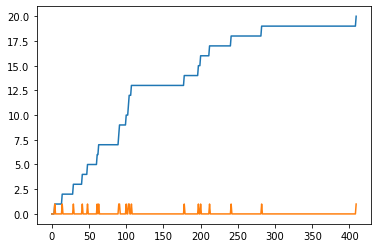

In [ ]:
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)

goal = model.datacollector.get_model_vars_dataframe()
#goal.plot()

ax.plot(goal)
plt.show

エージェントの属性は
```model.datacollector.get_agent_vars_dataframe()```
で取り出す．

In [ ]:
model.datacollector.get_agent_vars_dataframe()

Pos  Goal
Step AgentID              
0    0        (1, 4)     0
     1        (4, 5)     0
     2        (6, 5)     0
     3        (2, 0)     0
     4        (0, 4)     0
...              ...   ...
409  15       (2, 2)     1
     16       (2, 2)     1
     17       (2, 2)     1
     18       (2, 2)     1
     19       (2, 2)     1

[8200 rows x 2 columns]

取り出したデータコレクターの情報はPandasのDataFrameになっている．
Multi Indexになっているために扱いに注意する．

例えばステップ1の情報にアクセスしたいときには以下のようにする．


In [ ]:
model.datacollector.get_agent_vars_dataframe().loc[0]

2番目のindex(この場合はAgentの番号）でアクセスしたいときは，
```xs``メソッドとレベルを使ってアクセスする．

例えばAgentID 0のPosのみを取り出したいときは以下のようにする．

In [ ]:
model.datacollector.get_agent_vars_dataframe().xs(0, level='AgentID')['Pos']

In [ ]:
model.datacollector.get_agent_vars_dataframe().loc[0]

Step 0 の各エージェントの座標を取り出す．

In [ ]:
x = []
y = []
agent_loc = model.datacollector.get_agent_vars_dataframe().xs(0, level='Step')['Pos']
for i in range(len(agent_loc)):
  x.append(agent_loc[i][0])
  y.append(agent_loc[i][1])

In [ ]:
y

任意のステップにおけるエージェントの座標をプロットする

In [ ]:
agent_counts = np.zeros((model.grid.width, model.grid.height))
for agent_loc in model.datacollector.get_agent_vars_dataframe().xs(100, level='Step')['Pos']:
  x, y = agent_loc
  agent_counts[x][y] += 1
plt.imshow(agent_counts, interpolation='nearest')

plt.colorbar()

任意の世代におけるエージェントの座標をプロットする その1

In [ ]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

x = []
y = []
agent_loc = model.datacollector.get_agent_vars_dataframe().xs(1, level='Step')['Pos']
for i in range(len(agent_loc)):
  x.append(agent_loc[i][0])
  y.append(agent_loc[i][1])

ax.scatter(x, y, s=600, c="red", marker="*")
plt.show()


各エージェントの座標はタプルのリストになっている．
タプルのリストからx座標とy座標それぞれのリストを取り出してプロットする．
こっちの方がエレガント


In [ ]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

agent_loc = model.datacollector.get_agent_vars_dataframe().xs(1, level='Step')['Pos']
x, y = [a for a, b in agent_loc], [b for a, b in agent_loc]
ax.scatter(x, y, s=600, c="red", marker="*")
ax.set_title('evacuation')
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.show()

アニメーションしてみる

In [ ]:
fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(111)

ims=[]
for i in range(100): 
  agent_loc = model.datacollector.get_agent_vars_dataframe().xs(i, level='Step')['Pos']
  x, y = [a for a, b in agent_loc], [b for a, b in agent_loc]
  im = ax.scatter(x, y, s=600, c="red", marker="*")
# グラフをリストに加える
  ims.append([im])

ax.set_title('evacuation')
ax.set_xlabel('x')
ax.set_ylabel('y')

#fig.show()


# ArtistAnimationにfigオブジェクトとimsを代入してアニメーションを作成
anim = animation.ArtistAnimation(fig, ims)

# Google Colaboratoryの場合必要
rc('animation', html='jshtml')
plt.close()
anim

In [ ]:
fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(111)

goal = model.datacollector.get_model_vars_dataframe()
ax.plot(goal)


グラフを追加してアニメーションしてみる

In [ ]:
fig = plt.figure(figsize = (5, 10))
ax = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ims=[]
for i in range(100): 
  agent_loc = model.datacollector.get_agent_vars_dataframe().xs(i, level='Step')['Pos']
  x, y = [a for a, b in agent_loc], [b for a, b in agent_loc]
  im = ax.scatter(x, y, s=600, c="red", marker="*")
  goal = model.datacollector.get_model_vars_dataframe()[0:i]
  im2 = ax2.plot(goal)

# グラフをリストに加える
  ims.append([im])

ax.set_title('evacuation')
ax.set_xlabel('x')
ax.set_ylabel('y')

fig.show()


# ArtistAnimationにfigオブジェクトとimsを代入してアニメーションを作成
anim = animation.ArtistAnimation(fig, ims)

# Google Colaboratoryの場合必要
rc('animation', html='jshtml')
plt.close()
anim

In [ ]:
fig = plt.figure(figsize = (5, 10))
ax = fig.add_subplot(211)

ims=[]
for i in range(100): 
  goal = model.datacollector.get_model_vars_dataframe()[0:i]
  im = ax.plot(goal)

# グラフをリストに加える
  ims.append(im)

fig.show()


# ArtistAnimationにfigオブジェクトとimsを代入してアニメーションを作成
anim = animation.ArtistAnimation(fig, ims)

# Google Colaboratoryの場合必要
rc('animation', html='jshtml')
plt.close()
anim

アニメーションしてみる

In [ ]:
x = np.linspace(0,2*np.pi, 100) 

# fig, axオブジェクトを作成
fig, ax = plt.subplots()

# グラフのリスト作成
ims=[]
for i in range(10): 
    y = np.sin(x + 2*np.pi*(i/10))
    im = ax.plot(x, y, color='b')
    # グラフをリストに加える
    ims.append(im)

# 各軸のラベル
ax.set_xlabel(r"$x$", fontsize=15)
ax.set_ylabel(r"$y$", fontsize=15)
# グラフの範囲を設定
ax.set_xlim([0, 2*np.pi])
ax.set_ylim([-1.5, 1.5]) 

# ArtistAnimationにfigオブジェクトとimsを代入してアニメーションを作成
anim = animation.ArtistAnimation(fig, ims)

# Google Colaboratoryの場合必要
rc('animation', html='jshtml')
plt.close()
anim

アニメーションしてみる

In [ ]:
# アニメーションをしてみる
model = EvacModel(20, 10, 10, 2, 2)

%matplotlib inline
fig, ax = plt.subplots()
artists = []

for i in range(100):
  model.step
  agent_counts = np.zeros((model.grid.width, model.grid.height))
  for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
 
  #plt.cla()
  map = plt.imshow(agent_counts, interpolation='nearest')
  #colorbar = plt.colorbar()
  #artists.append([map, colorbar])
  artists.append(map)
 
anim = ArtistAnimation(fig, artists, interval=10, repeat_delay=1000)

#rc('animation', html='jshtml')
#plt.close()
anim


In [ ]:
model = MoneyModel(9, 3, 3, 2, 2)
for i in range(20):
    model.step()


In [ ]:

# For a jupyter notebook add the following line:
%matplotlib inline

# The below is needed for both notebooks and scripts

agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
plt.imshow(agent_counts, interpolation='nearest')
plt.colorbar()


In [ ]:


# If running from a text editor or IDE, remember you'll need the following:
# plt.show()

model = MoneyModel(9, 3, 3, 2, 2)
for i in range(100):
    model.step()

gini = model.datacollector.get_model_vars_dataframe()
gini.plot()

agent_wealth = model.datacollector.get_agent_vars_dataframe()
agent_wealth.head()

end_wealth = agent_wealth.xs(99, level="Step")["Wealth"]
end_wealth.hist(bins=range(agent_wealth.Wealth.max()+1))

one_agent_wealth = agent_wealth.xs(14, level="AgentID")
one_agent_wealth.Wealth.plot()

In [ ]:
for i in range(10, 100):
  print(i)  

だいち

10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


**中山大地**



大地だいちだいち
